In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from qmc import *
from functions import bootstrap, blocking
figsize = (8, 8)
axis_fontsize = 26
title_fontsize = 20
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex = True)

/Users/bendik/drive/uio/10.semester/fys4411/projects/python /Users/bendik/drive/uio/10.semester/fys4411/projects /Users/bendik/drive/uio/10.semester/fys4411/projects/include /Users/bendik/drive/uio/10.semester/fys4411/projects/build-release
Found libraries: ['/Users/bendik/drive/uio/10.semester/fys4411/projects/build-release/libengine.dylib']
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/hamiltonian.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/prettyprint.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/rbm.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/combinedcalculator.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/vector.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/system.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/wavefunction.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/v

# Utility Functions

In [2]:
def cpp_class_name(obj):
    name = repr(obj)
    return re.match("^.*gbl\.(\w+)\s", repr(name)).group(1)

def training_plot(target, rbm, H, sampler, iters, samples, lr=0.01, gamma=0, optimizer=None, saveas=None, verbose=False, plot_points=100, return_E=False):
    def eval():
        return abs(H.local_energy(sampler.next_configuration(), rbm) - target)
    
    if optimizer is None:
        optimizer = SgdOptimizer(lr)
    
    E = [sum(eval() for _ in range(samples)) / samples]
    param = [vector_to_array(rbm.get_parameters())]
    rounds_per_iteration = max(1, iters // plot_points)
    for i in range(min(iters, plot_points)):
        rbm.train(H, sampler, rounds_per_iteration, samples, optimizer, gamma, False)
        E.append(sum(eval() for _ in range(samples)) / samples)
        if verbose:
            print('E =', E[-1], flush=True)
        param.append(vector_to_array(rbm.get_parameters()))
    
    param = np.asarray(param)
    
    if return_E:
        return E
    
    fig, ax = plt.subplots(sharex=True, nrows=2, ncols=1, figsize=figsize)
    ax[0].semilogy(E, label=r'$\langle E_L\rangle$')
    ax[0].set_ylabel(r'$\langle E_L\rangle$ [a.u.]', fontsize=axis_fontsize-5)
    for i in range(rbm.get_parameters().size()):
        ax[1].plot(param[:,i], label=r'$\alpha_{%d}$' % i)
    ax[1].set_xlabel('Training iterations (x{})'.format(rounds_per_iteration), fontsize=axis_fontsize-5)
    plt.legend(fontsize=title_fontsize-5)
    
    if saveas:
        plt.savefig(saveas)

def multiplot(target, rbms, H, samplers, optimizers, iters, samples, gamma=0, saveas=None, verbose=False, labels=None):
    initial_params = array_to_vector(vector_to_array(rbms[0].get_parameters()))
    fig, ax = plt.subplots(figsize=figsize)
    for rbm, sampler in zip(rbms, samplers):
        for optimizer in optimizers:
            rbm.set_parameters(initial_params)
            E = training_plot(target, rbm, H, sampler, iters, samples, 
                              gamma=gamma, optimizer=optimizer, return_E=True, verbose=verbose)
            ax.semilogy(E, label='{} and {}'.format(cpp_class_name(sampler), cpp_class_name(optimizer)))
   
    ax.set_ylabel(r'Error in $\langle E_L\rangle$ [a.u.]', fontsize=axis_fontsize-5)
    ax.set_xlabel(r'Training iterations (percent of training)', fontsize=axis_fontsize-5)
    if labels:
        plt.legend(labels, fontsize=title_fontsize-5)
    if saveas:
        plt.savefig(saveas)
            
def onebodydensity_plot(H, sampler, n_bins, max_radius, samples, saveas=None):
    rho = vector_to_array(H.onebodydensity(sampler, n_bins, max_radius, samples))
    r = np.linspace(0, max_radius, len(rho))

    rho /= np.trapz(rho, x=r)
    
    exact = np.exp(- r**2)
    exact = exact / np.trapz(exact, x=r)


    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(r, rho, label='RBM')
    ax.plot(r, exact, label='Exact')
    ax.set_xlabel(r'$r/r_0$', fontsize=axis_fontsize-5)
    ax.set_ylabel(r'$\rho_i$', fontsize=axis_fontsize-5)
    plt.legend(fontsize=title_fontsize-5)
    
    if saveas:
        plt.savefig(saveas)

# One electron, 1D

In [3]:
P, D = 1, 1
M = P * D
N = 2
sigma2 = 1
system = System(P, D)
H = RBMHarmonicOscillatorHamiltonian()

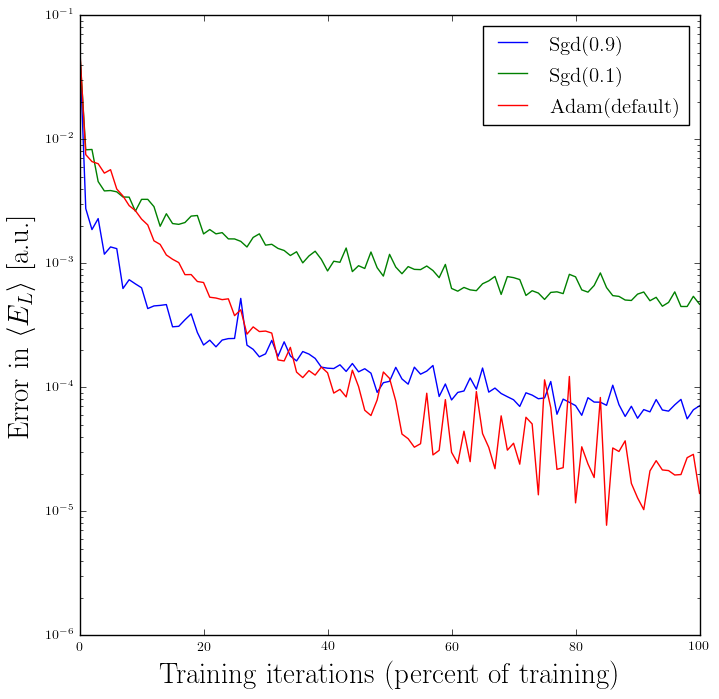

In [4]:
rbms = [RBMWavefunction(M, N, sigma2)]
samplers = [ImportanceSampler(system, rbms[0], 0.5)]
optimizers = [SgdOptimizer(0.9), SgdOptimizer(0.1), AdamOptimizer(rbms[0].get_parameters().size())]
labels = 'Sgd(0.9)', 'Sgd(0.1)', 'Adam(default)'
multiplot(0.5, rbms, H, samplers, optimizers, 20000, 100, labels=labels, saveas='../results/learning-optimizers.png')

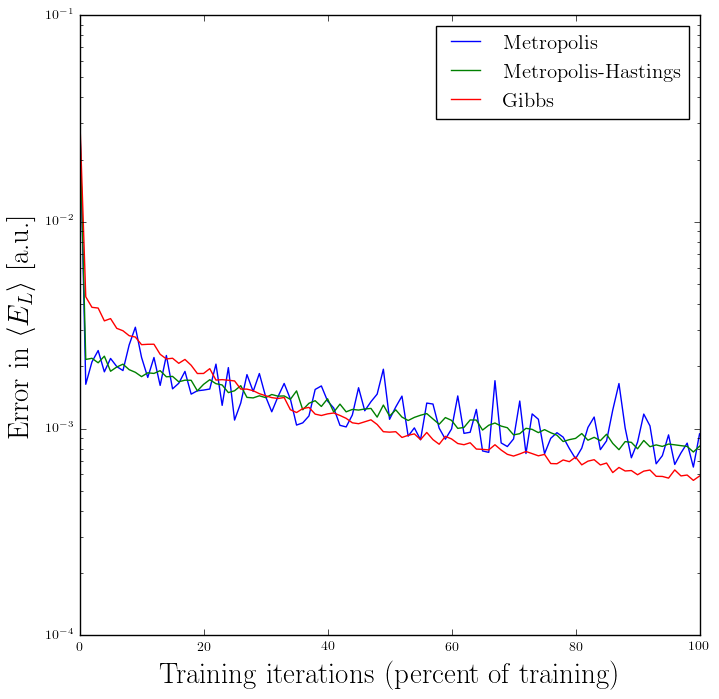

In [5]:
rbms = [RBMWavefunction(M, N, sigma2), RBMWavefunction(M, N, sigma2), RBMWavefunction(M, N, RBMWavefunction.GIBBS_FACTOR * sigma2, RBMWavefunction.GIBBS_FACTOR)]
samplers = [MetropolisSampler(system, rbms[0], 0.5), ImportanceSampler(system, rbms[1], 0.5), GibbsSampler(system, rbms[2])]
optimizers = [SgdOptimizer(0.1)]
labels = 'Metropolis', 'Metropolis-Hastings', 'Gibbs'
multiplot(0.5, rbms, H, samplers, optimizers, 10000, 1000, labels=labels, saveas='../results/learning-samplers.png')

# Standard Metropolis

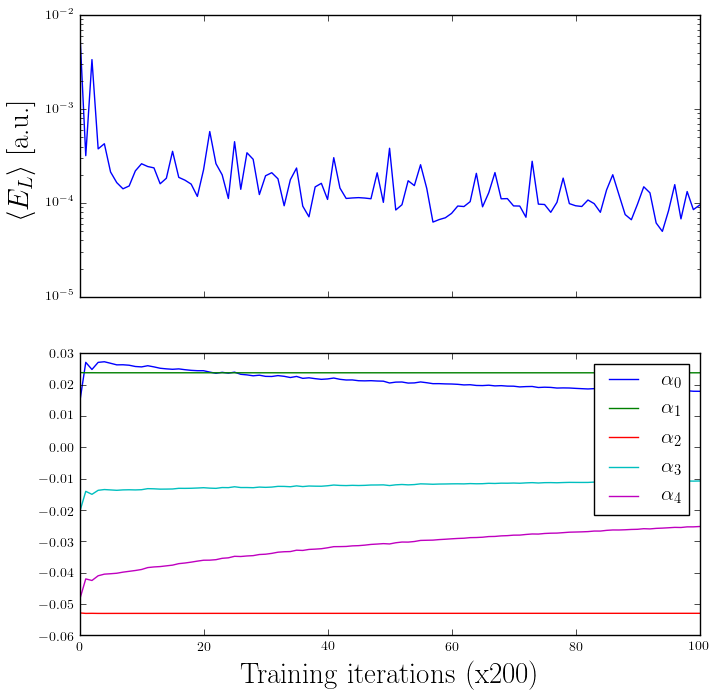

In [14]:
rand_gen.seed(123)
rbm = RBMWavefunction(M, N, sigma2)
initial_params = array_to_vector(vector_to_array(rbm.get_parameters()))  # Copy for later use.
sampler = MetropolisSampler(system, rbm, 0.5)
training_plot(0.5, rbm, H, sampler, 20000, 100, 0.9, saveas='../results/rbm-1d-1p-training-lr-09-metro.png', plot_points=100)

In [15]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

(0.5000000955643229, 2.6875813367117693e-08, 1.3138327943791218e-06)

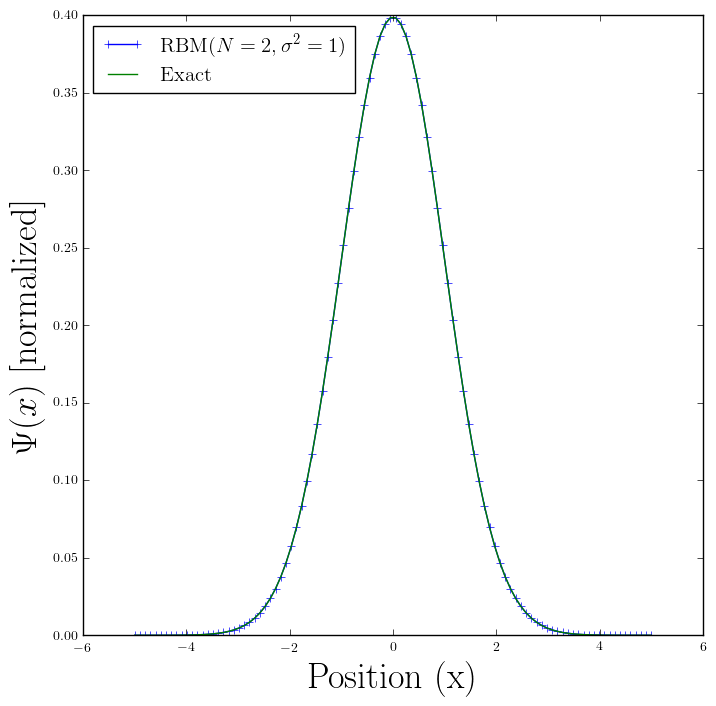

In [16]:
x_array = np.linspace(-5, 5, 100)
s_array = np.asarray([array_to_system(np.array([[x]])) for x in x_array])

learned = np.asarray([rbm(s_i) for s_i in s_array])
learned_norm = learned / np.trapz(learned, x=x_array)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(x_array, learned_norm, '-+', label='RBM($N={}, \sigma^2 = {}$)'.format(N, sigma2))
ax.plot(x_array, (2*np.pi)**(-0.5) * np.exp(-0.5 * x_array**2), label='Exact')
ax.set_xlabel('Position (x)', fontsize=axis_fontsize)
ax.set_ylabel(r'$\Psi(x)$ [normalized]', fontsize=axis_fontsize)
plt.legend(fontsize=title_fontsize-5, loc='upper left')
plt.savefig('../results/rbm-1d-1p.png')

## Importance Sampling

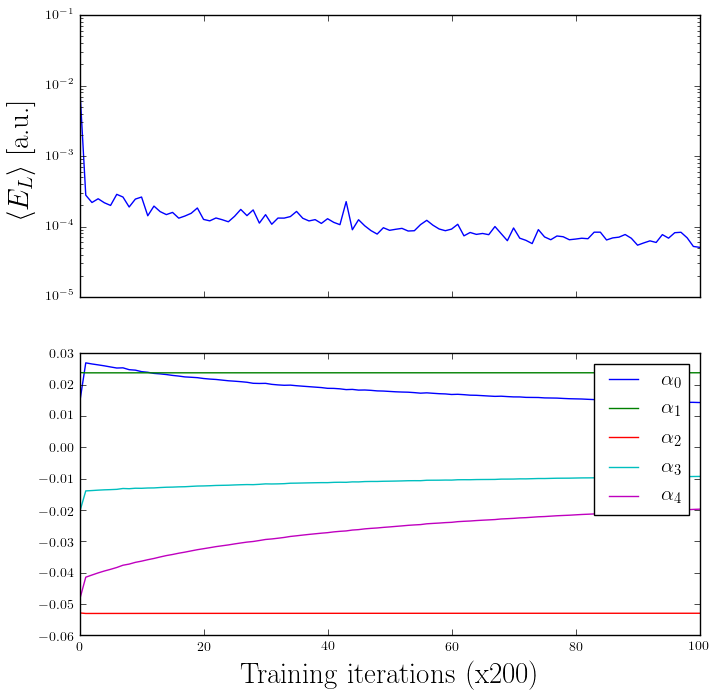

In [17]:
rbm = RBMWavefunction(M, N, sigma2)
rbm.set_parameters(initial_params)
sampler = ImportanceSampler(system, rbm, 0.5)
training_plot(0.5, rbm, H, sampler, 20000, 100, 0.9, 0.0, saveas='../results/rbm-1d-1p-training-lr-09-imp.png')

In [18]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

(0.50000003693280526, 7.2889113157394403e-09, 1.1034421458591689e-07)

## Gibbs Sampling

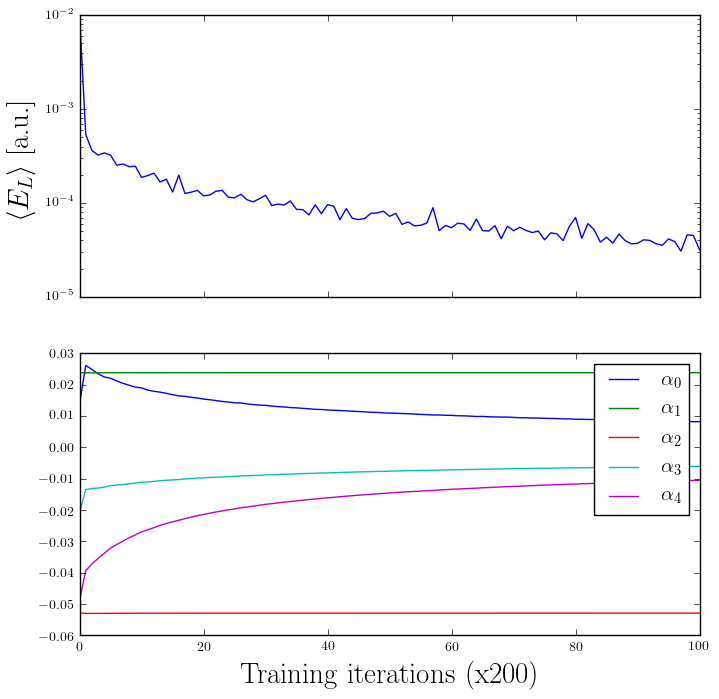

In [19]:
rbm = RBMWavefunction(M, N, 0.5, RBMWavefunction.GIBBS_FACTOR)
rbm.set_parameters(initial_params)
sampler = GibbsSampler(system, rbm)
training_plot(0.5, rbm, H, sampler, 20000, 100, 0.9, 0.0, saveas='../results/rbm-1d-1p-training-lr-09-gibbs.png')

In [20]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

(0.49999999815673413, 2.737920340631941e-09, 5.188610985347837e-08)

# More dimensions, more particles

In [21]:
P, D = 2, 2
M = P * D
N = M - 2
sigma2 = 0.5
system = System(P, D)
H = RBMHarmonicOscillatorHamiltonian()

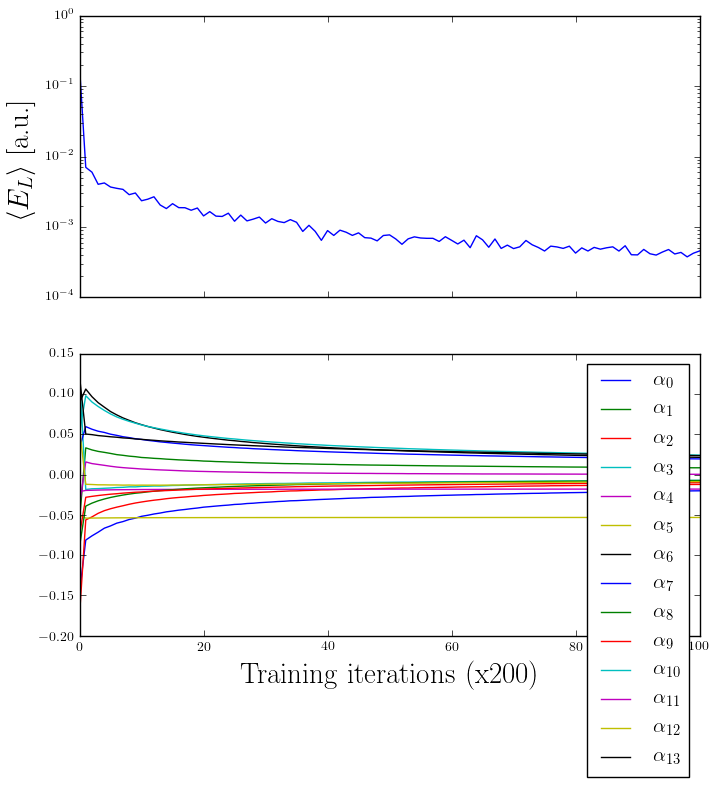

In [22]:
rbm = RBMWavefunction(M, N, sigma2, RBMWavefunction.GIBBS_FACTOR)
sampler = GibbsSampler(system, rbm)
training_plot(2, rbm, H, sampler, 20000, 100, 0.1, 0.0, saveas='../results/rbm-{}d-{}p-training-lr-01-imp.png'.format(D, P))

In [23]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

(1.9999990192029551, 3.2815726525741948e-07, 5.660091019153718e-07)

In [24]:
H.mean_distance(sampler, 2**20)

1.2530687572898989

In [25]:
viral = np.empty((2**20, 2))
for i in range(viral.shape[0]):
    s = sampler.next_configuration()
    viral[i, 0] = H.kinetic_energy(s, rbm)
    viral[i, 1] = H.external_potential(s) + H.internal_potential(s)
K, V = viral.T
np.mean(K), np.mean(V)

(0.99940905616036735, 1.0005909487886746)

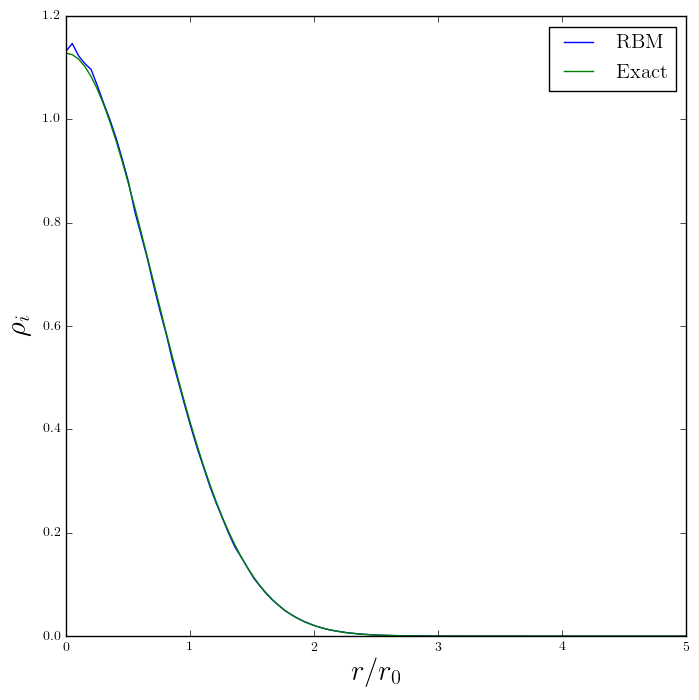

In [26]:
onebodydensity_plot(H, sampler, 100, 5, 2**20)

# Interaction

In [ ]:
P, D = 2, 2
M = 4
N = 10
sigma2 = 1
system = System(P, D)
H = RBMInteractingHamiltonian()

rbm = RBMWavefunction(M, N, sigma2)
sampler = ImportanceSampler(system, rbm, 0.5)

In [ ]:
training_plot(3, rbm, H, sampler, 200, 1000, 0.1, 0.0, saveas='../results/rbm-{}d-{}p-training-lr-01-imp-int.png'.format(D, P), verbose=True)
#rbm.set_parameters(array_to_vector([0.00558939, -0.00127114, 0.00607415, 0.00902971, -0.000179985, 0.000215826, -0.000180828, -0.000102407, -2.36379e-05, -0.00014657, -3.33483e-05, 0.000125316, 7.87813e-05, 0.000105316, 0.0023596, 0.00235957, 0.00236114, 0.00235911, 0.00236029, 0.00235974, 0.00235971, 0.00236019, 0.00235944, 0.00236027, -0.00415567, -0.00414472, -0.00415803, -0.00416652, -0.00416286, -0.00415857, -0.00414728, -0.00415043, -0.00409265, -0.00416274, 0.00283797, 0.00282533, 0.00283447, 0.00282469, 0.00282476, 0.00282573, 0.00282471, 0.00282712, 0.00282527, 0.00282542, 0.00503891, 0.00504268, 0.00503889, 0.00503624, 0.00503876, 0.00503912, 0.00503649, 0.00503917, 0.00503749, 0.00503915]))

In [ ]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

In [ ]:
H.mean_distance(sampler, 2**20)

In [ ]:
onebodydensity_plot(H, sampler, 100, 5, 2**20)

In [ ]:
viral = np.empty((2**20, 2))
for i in range(viral.shape[0]):
    s = sampler.next_configuration()
    viral[i, 0] = H.kinetic_energy(s, rbm)
    viral[i, 1] = H.external_potential(s) + H.internal_potential(s)
K, V = viral.T
np.mean(K), np.mean(V)